# BreezeAPI Options Strategy

## Install BreezeAPI package

In [ ]:
pip install --upgrade breeze-connect

In [ ]:
pip install --upgrade mplfinance

In [ ]:
pip install --upgrade matplotlib

In [ ]:
pip install --upgrade pandas_ta

## Import required packages

In [1]:
from breeze_connect import BreezeConnect
from datetime import datetime
import urllib
import numpy as np
import pandas as pd

import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas_ta as ta


## Variables for initial setup

In [2]:
Api_key="^42y6975650632#94258t282@r718`77"
Api_Secret="i0td81HE339202156w96102D98497633"

## Get Link to generate session key

In [3]:
print("https://api.icicidirect.com/apiuser/login?api_key="+urllib.parse.quote_plus(Api_key))

https://api.icicidirect.com/apiuser/login?api_key=%5E42y6975650632%2394258t282%40r718%6077


## Declare Session key variable

In [4]:
Api_Session="39245717"

## Initialize SDK

In [5]:
breeze = BreezeConnect(api_key=Api_key)

## Generate Session

In [6]:
breeze.generate_session(api_secret=Api_Secret,
                        session_token=Api_Session)


## Indicator process

In [32]:
currentDate=datetime.now()
fromDate=datetime(currentDate.year-1,currentDate.month, currentDate.day)
print(fromDate)
histryData=breeze.get_historical_data_v2(interval="5minute",
                            from_date= fromDate.strftime('%Y-%m-%dT%H:%M:%S.000Z'),
                            to_date= currentDate.strftime('%Y-%m-%dT%H:%M:%S.000Z'),
                            stock_code="NIFTY",
                            exchange_code="NSE",
                            product_type="cash",
                            expiry_date="2024-04-25T07:00:00.000Z",
                            right="others",
                            strike_price="0")['Success']
histryData
df=pd.DataFrame(histryData)
df.set_index("datetime")
df.drop(['exchange_code','stock_code','volume'],axis=1, inplace=True)

# Calculate EMA 10 fast
df['ema_10']=df['close'].ewm(span=10).mean()

# Calculate EMA 30 slow
df['ema_30']=df['close'].ewm(span=30).mean()

# Calculate MACD
macdDf=ta.macd(close=df['close'],fast=12,slow=26,signal=9)
df['macd']=macdDf['MACD_12_26_9']
df['macd_signal']=macdDf['MACDs_12_26_9']
df['macd_histogram']=macdDf['MACDh_12_26_9']

# Calculate SuperTrend with factor 20,2
superTrenddf=ta.supertrend(high=df['high'],low=df['low'],close=df['close'], multiplier=20,offset=2)
df['superTrend']=superTrenddf['SUPERT_7_20.0']
df['supertrend_signal']=superTrenddf['SUPERTd_7_20.0']
df.to_csv("data.csv",)
df

2023-04-23 00:00:00


,close,datetime,high,low,open,ema_10,ema_30,macd,macd_signal,macd_histogram,superTrend,supertrend_signal
0,22469.05,2024-04-01 15:25:00,22473.90,22456.50,22459.00,22469.050000,22469.050000,NaN,NaN,NaN,NaN,NaN
1,22458.80,2024-04-02 09:05:00,22458.80,22458.80,22458.80,22463.412500,22463.754167,NaN,NaN,NaN,NaN,NaN
2,22458.80,2024-04-02 09:10:00,22458.80,22458.80,22458.80,22461.558306,22461.991503,NaN,NaN,NaN,0.000000,1.0
3,22435.55,2024-04-02 09:15:00,22462.40,22426.20,22458.80,22452.989728,22454.705905,NaN,NaN,NaN,NaN,1.0
4,22430.60,2024-04-02 09:20:00,22438.30,22415.90,22435.20,22446.562246,22449.221228,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,22326.30,2024-04-22 15:05:00,22327.15,22314.55,22316.40,22308.908807,22294.322451,9.942846,6.954058,2.988789,22033.240926,1.0
996,22347.05,2024-04-22 15:10:00,22349.35,22321.20,22326.10,22315.843570,22297.724229,12.426942,8.048634,4.378307,22035.652353,1.0
997,22344.75,2024-04-22 15:15:00,22347.40,22334.90,22347.40,22321.099284,22300.758149,14.048077,9.248523,4.799554,22045.409159,1.0
998,22354.50,2024-04-22 15:20:00,22356.25,22338.45,22344.00,22327.172142,22304.225366,15.935883,10.585995,5.349888,22045.409159,1.0


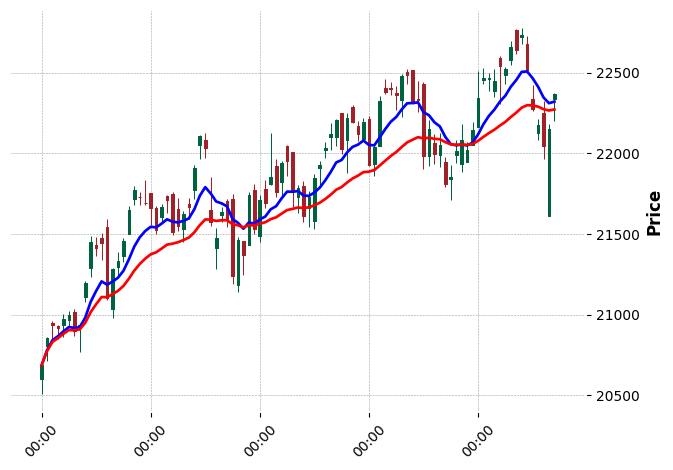

In [28]:
df.index=pd.to_datetime(df.index)

ema10_plot=mpf.make_addplot(data=df['ema_10'],color='b')
ema30_plot=mpf.make_addplot(data=df['ema_30'],color='r')


mpf.plot(df,type='candle', style='charles',volume=False, addplot=[ema10_plot, ema30_plot])

In [ ]:
# demo strategy, if ema_9 crosses up ema_26, buy
# else if ema_9 crosses down ema_26, sell